Main driver script for the QAOA Protein Folding experiment.

This script ties all modules together:
1.  Loads sequence and lattice data.
2.  Builds the cost (H_C) and mixer (H_M) Hamiltonians.
3.  Runs the QAOA optimization.
4.  Interprets and visualizes the results.

In [1]:
# Import Libraries
import sys
import pprint
import random
random.seed(42)

# --- Import all project modules ---
try:
    from hp import hp_mapping, encode_hp_sequence
    from lattice import bcc_neighbors, fcc_neighbors, cpd_neighbors, sc_neighbors
    from hamiltonian import (
        build_coordinate_operators, 
        build_cost_hamiltonian, 
        build_mixer_hamiltonian,
        mj_matrix  # Using the mock matrix from hamiltonian.py
    )
    from folding_qaoa import run_qaoa_optimization
    from results_interpreter import interpret_qaoa_results, analyze_energy_landscape, visualize_protein_fold

    # Print confirmation when all imports succeed
    print("✅ All project modules have been successfully loaded.")

except ImportError as e:
    print(f"❌ Error: Missing a required module. {e}")
    print("Please ensure all .py files are in the same directory.")
    sys.exit(1)

✅ All project modules have been successfully loaded.


In [2]:
# ==================================================================
# 1. EXPERIMENT CONFIGURATION
# ==================================================================

# --- Sequence Definition ---
sequence = ["A", "S", "V", "K", "F"]
# sequence = ["H", "P", "H", "P", "H"] # A simple test sequence

# Encode HP sequence
hp_sequence, num_residues = encode_hp_sequence(sequence)

if num_residues < 2:
    print("Error: Sequence must have at least 2 residues.")
    sys.exit(1)

# --- Lattice Selection ---
# Choose one: fcc_neighbors, cpd_neighbors, bcc_neighbors
lattice_name = "BCC"
neighbors = bcc_neighbors

# --- QAOA Parameters ---
qaoa_reps = 3       # Number of QAOA layers (p)
opt_maxiter = 100    # Max iterations for COBYL
final_shots = 4096  # Shots for final measurement

# --- Energy parameters (can be tuned) ---
hamiltonian_params = {
    "W_hh": 2.0,         # Magnitude of HP reward
    "P_overlap": 500.0,  # Penalty for overlapping
    "P_invalid": 5.0,  # Penalty for invalid plane '00'
    "max_separation": num_residues  # Max residues apaaaafff
}

In [3]:
# ==================================================================
# 2. PRE-PROCESSING
# ==================================================================

print("="*70)
print("  QAOA PROTEIN FOLDING - MAIN DRIVER")
print("="*70)
print(f"Sequence: {sequence}")
print(f"Lattice: {lattice_name} ({len(neighbors)} neighbors)")
print(f"QAOA Reps (p): {qaoa_reps}")
print(f"Optimizer Iterations: {opt_maxiter}")
print("\nHamiltonian Parameters:")
pprint.pprint(hamiltonian_params)



  QAOA PROTEIN FOLDING - MAIN DRIVER
Sequence: ['A', 'S', 'V', 'K', 'F']
Lattice: BCC (8 neighbors)
QAOA Reps (p): 3
Optimizer Iterations: 100

Hamiltonian Parameters:
{'P_invalid': 5.0, 'P_overlap': 500.0, 'W_hh': 2.0, 'max_separation': 5}


In [4]:
# ==================================================================
# 3. HAMILTONIAN CONSTRUCTION
# ==================================================================

try:
    # --- Step 1: Build Coordinate Operators ---
    coord_ops, invalid_plane_ops, props, I_op = build_coordinate_operators(sequence, neighbors)
    
    # --- Step 2: Build Cost Hamiltonian (H_C) ---
    H_C = build_cost_hamiltonian(
        sequence,
        hp_sequence,
        coord_ops,
        invalid_plane_ops,
        props,
        I_op,
        hamiltonian_params
    )
    
    # --- Step 3: Build Mixer Hamiltonian (H_M) ---
    H_M = build_mixer_hamiltonian(props['total_qubits'])

except (ValueError, NotImplementedError, np.linalg.LinAlgError) as e:
    print(f"\n" + "="*70)
    print(f"❌ FATAL ERROR during Hamiltonian construction: {e}")
    print("Please check your lattice choice and sequence.")
    sys.exit(1)

Constructed coordinate operators for BCC (5 residues, 12 qubits).
Building H_Rewards (non-contact) and H_Overlap (max_separation = 5)...
...H_Rewards built. Terms: 130
...H_Overlap built. Terms: 130
Building H_Invalid...
...H_Invalid built. Terms: 1
Combining Hamiltonian terms...

--- Cost Hamiltonian H_C ---
Number of terms in H_C: 130

Building H_M (Sum of Pauli-X operators) for 12 qubits...
...H_M built.
Number of terms in H_M: 12


In [5]:
# ===== VALIDATION CELL =====
# Check sequence validity

print("="*60)
print("SEQUENCE VALIDATION")
print("="*60)

# Check residue codes
valid_residues = set(hp_mapping.keys())
for aa in sequence:
    if aa not in valid_residues:
        print(f"❌ ERROR: Invalid residue '{aa}'")
        print(f"   Valid residues: {sorted(valid_residues)}")
        sys.exit(1)

# Check sequence length
if len(sequence) < 2:
    print("❌ ERROR: Sequence too short (minimum 2 residues)")
    sys.exit(1)

if len(sequence) > 20:
    print("⚠️  WARNING: Large sequence. May require more qubits.")
    print(f"   {len(sequence)} residues → {props.get('total_qubits', 'unknown')} qubits")

# HP analysis
hp_seq, m = encode_hp_sequence(sequence)
num_hydro = sum(1 for h in hp_seq if h == 'H')
num_polar = m - num_hydro

print(f"✅ Sequence: {' '.join(sequence)}")
print(f"✅ HP Model: {''.join(hp_seq)}")
print(f"✅ Hydrophobic residues: {num_hydro}/{m} ({100*num_hydro/m:.1f}%)")
print(f"✅ Polar residues: {num_polar}/{m} ({100*num_polar/m:.1f}%)")

if num_hydro == 0:
    print("⚠️  WARNING: No hydrophobic residues. Folding will be driven only by MJ potential.")
if num_hydro == m:
    print("⚠️  WARNING: All hydrophobic. May form compact but unbiological fold.")

print(f"✅ Lattice: {lattice_name}")
print(f"✅ Total qubits: {props['total_qubits']}")
print()

SEQUENCE VALIDATION
✅ Sequence: A S V K F
✅ HP Model: HPHPH
✅ Hydrophobic residues: 3/5 (60.0%)
✅ Polar residues: 2/5 (40.0%)
✅ Lattice: BCC
✅ Total qubits: 12




  QAOA OPTIMIZATION SETUP
Backend: aer_simulator_statevector (method: statevector)

✓ QAOA Circuit created:
  - Layers (p): 3
  - Total qubits: 12
  - Parameters: 6

✓ Transpiler configured (level 1)
Using Statevector-based expectation (H_C is non-diagonal).

  STARTING OPTIMIZATION
Optimizer: COBYLA
Max iterations: 100
Initial parameters (fixed): [0.1 0.1 0.1 0.1 0.1 0.1]
------------------------------------------------------------
✓ Iter   1: E = 8935.1968 (NEW BEST)
✓ Iter   2: E = 8541.2378 (NEW BEST)
✓ Iter   3: E = 7298.7960 (NEW BEST)
  Iter   5: E = 11186.9221
  Iter  10: E = 12513.2130
  Iter  15: E = 11376.0627
✓ Iter  19: E = 6972.8688 (NEW BEST)
  Iter  20: E = 12096.1434
  Iter  25: E = 7012.4609
✓ Iter  27: E = 6947.4539 (NEW BEST)
✓ Iter  29: E = 6897.5664 (NEW BEST)
  Iter  30: E = 6897.6529
✓ Iter  31: E = 6896.5859 (NEW BEST)
✓ Iter  35: E = 6894.0915 (NEW BEST)
✓ Iter  36: E = 6893.1450 (NEW BEST)
✓ Iter  37: E = 6891.1591 (NEW BEST)
✓ Iter  38: E = 6890.8547 (NEW B

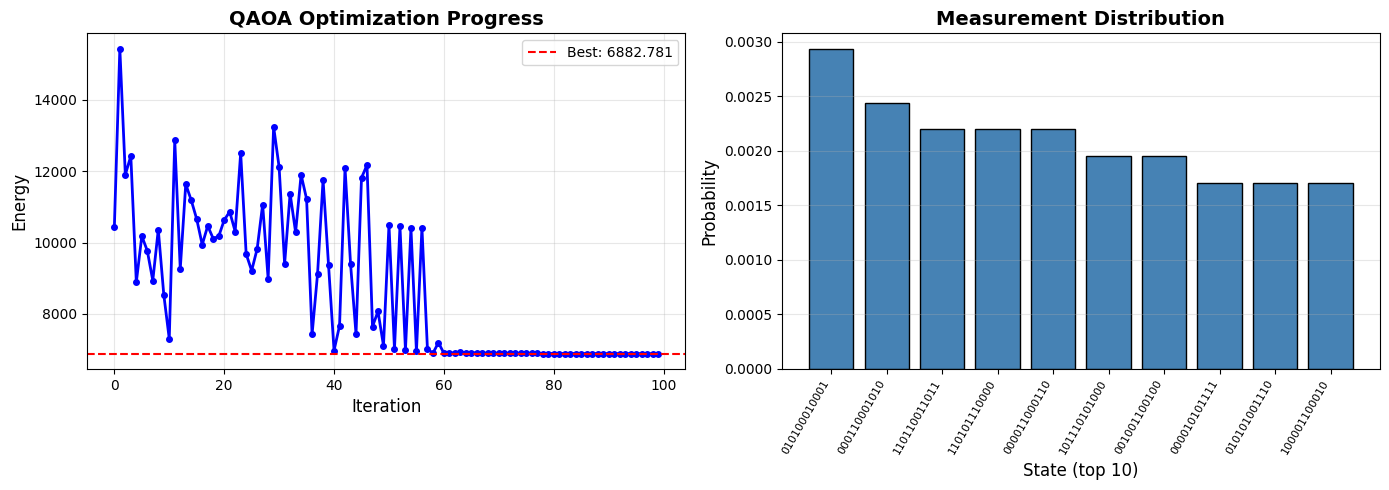


✅ QAOA ANALYSIS COMPLETE!
Total optimization runtime: 6.2 seconds


In [6]:
# ==================================================================
# 4. QAOA OPTIMIZATION
# ==================================================================
result, final_counts, energy_history, optimization_time = \
    run_qaoa_optimization(H_C, H_M, reps=qaoa_reps, maxiter=opt_maxiter)

# Analyze with decision logic
stats = analyze_energy_landscape(energy_history)

print("\n" + "="*70)
print("DECISION BASED ON ANALYSIS")
print("="*70)

if stats['recommendation'] == 'ACCEPT':
    print("✅ Proceeding with result interpretation...")
    
elif stats['recommendation'] == 'RETRY':
    print("⚠️  Results are marginal. Suggest re-running with:")
    print("   - qaoa_reps increased from {} to {}".format(
        qaoa_reps, qaoa_reps + 1))
    print("   - opt_maxiter increased from {} to {}".format(
        opt_maxiter, opt_maxiter + 50))
    
elif stats['recommendation'] == 'RESTART':
    print("❌ STOPPING: Optimizer failed")
    print("   Reduce P_overlap from {} to {}".format(
        hamiltonian_params['P_overlap'],
        hamiltonian_params['P_overlap'] / 2))
    sys.exit(1)

# Continue with interpretation
best_valid_coords = interpret_qaoa_results(
    result, final_counts, energy_history, optimization_time,
    sequence, hp_sequence, neighbors, mj_matrix, props, hamiltonian_params
)

In [7]:
fig = visualize_protein_fold(
    coords=best_valid_coords,
    sequence=sequence,
    hp_sequence=hp_sequence,
    lattice_name=lattice_name,
    neighbors=neighbors
)
fig.show()